In [1]:
import glob 
import random 
import dask.dataframe as dd


In [2]:

state_vector_sample_files = glob.glob("../../data/raw/state_vectors_samples/*.parquet")

# choose 3 random files
random_files = random.sample(state_vector_sample_files, 3)

# read the files
df = dd.read_parquet(random_files)

df.head()


,icao24,time,lat,lon,velocity,heading,vertrate,callsign,onground,spi,squawk,geoaltitude,baroaltitude
0,a3b88e,1719439014,33.26825,-84.427789,244.901821,179.157476,0.0,AAL1511,False,False,3156,9997.44,9448.8
1,a4a377,1719439014,34.110407,-83.809776,69.144412,342.239088,-5.85216,N3984T,False,False,<NA>,1470.66,1463.04
2,a46e0f,1719439014,34.558548,-84.90509,91.058041,52.806401,0.0,N385C,False,False,<NA>,<NA>,3360.42
3,a06f22,1719439014,33.621689,-83.77277,255.960577,48.911572,-8.128,EJA127,False,False,<NA>,7520.94,6926.58
4,aa79f6,1719439014,34.444094,-83.451004,201.96432,223.451842,-9.42848,AAL1992,False,False,2357,6111.24,5783.58


In [3]:
df.shape[0].compute()

2848887

icao24                0
time                  0
lat                   0
lon                   0
velocity          68722
heading           68722
vertrate          68722
callsign          57603
onground              0
spi                   0
squawk          1954678
geoaltitude      154612
baroaltitude     134076
dtype: int64


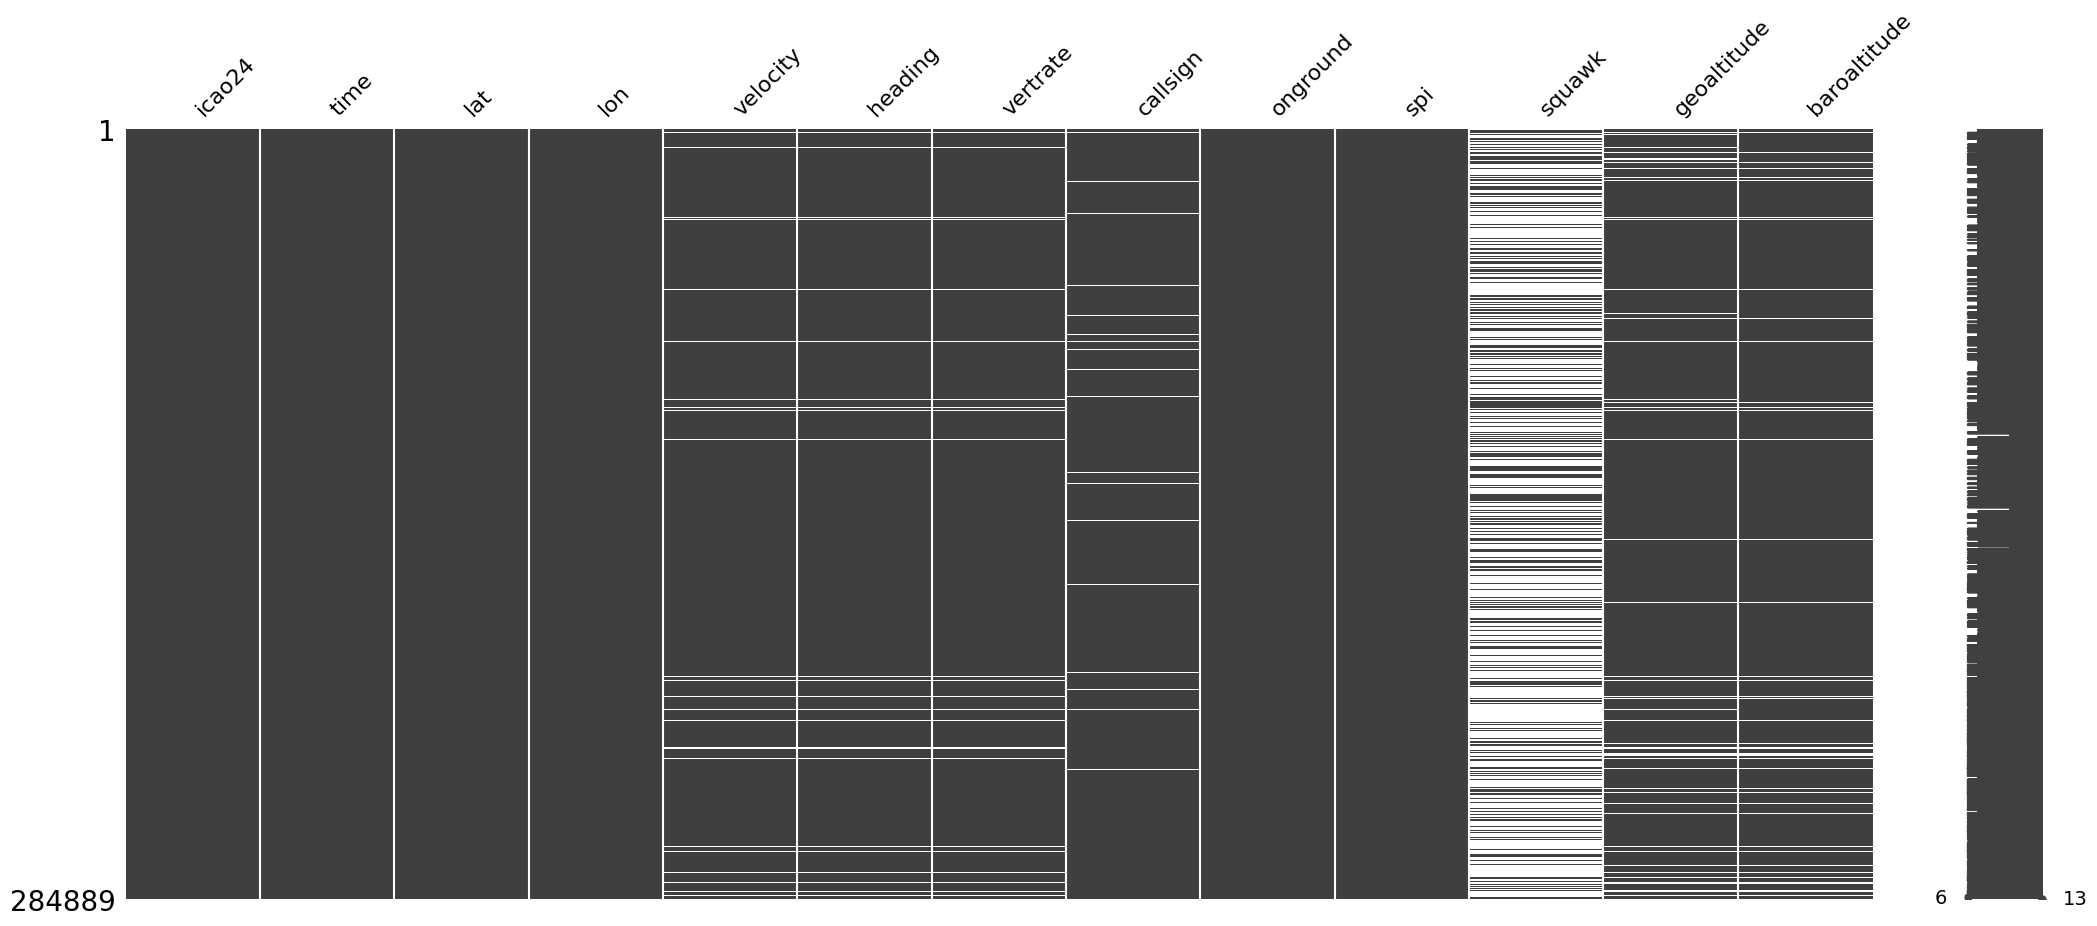

In [4]:
# missing analysis
import missingno as msno

# Convert a sample of the Dask DataFrame to pandas
# Adjust the sample size (0.1 = 10%) based on your data size and memory constraints
pandas_df = df.sample(frac=.10).compute()  # or use frac=0.1 for percentage-based sampling

# Now use missingno with the pandas DataFrame
msno.matrix(pandas_df)

# For missing values count, you can still use the full Dask DataFrame
missing_counts = df.isnull().sum().compute()
print(missing_counts)

We can drop squawk column and for velocity, heading, vertrate, callsign, geoaltitude, and baroaltitude we can impute with KNNImputer

In [5]:
from sklearn.impute import KNNImputer

# drop squawk column
df = df.drop(columns=['squawk'])

def impute_partition(pdf):
    imputer = KNNImputer(n_neighbors=5)
    # Impute the selected numeric columns in this Pandas partition
    pdf[['velocity', 'heading', 'vertrate', 'geoaltitude', 'baroaltitude']] = imputer.fit_transform(pdf[['velocity', 'heading', 'vertrate', 'geoaltitude', 'baroaltitude']])
    return pdf

# Apply the imputation to each partition
df = df.map_partitions(impute_partition)
df.head()

,icao24,time,lat,lon,velocity,heading,vertrate,callsign,onground,spi,geoaltitude,baroaltitude
0,a3b88e,1719439014,33.26825,-84.427789,244.901821,179.157476,0.00000,AAL1511,False,False,9997.44,9448.80
1,a4a377,1719439014,34.110407,-83.809776,69.144412,342.239088,-5.85216,N3984T,False,False,1470.66,1463.04
2,a46e0f,1719439014,34.558548,-84.90509,91.058041,52.806401,0.00000,N385C,False,False,3512.82,3360.42
3,a06f22,1719439014,33.621689,-83.77277,255.960577,48.911572,-8.12800,EJA127,False,False,7520.94,6926.58
4,aa79f6,1719439014,34.444094,-83.451004,201.964320,223.451842,-9.42848,AAL1992,False,False,6111.24,5783.58


In [6]:
missing_counts = df.isnull().sum().compute()
print(missing_counts)

: 

## Georgia Data Analysis

Over interval of 12 hours over Georgia Bounds

In [2]:
import dask.dataframe as dd

df = dd.read_parquet("../../data/georgia_data_2/georgia_complete_dataset.parquet")
df.head(10)


,time,icao24,callsign,latitude,longitude,altitude,velocity,heading,vertrate,onground
0,2025-01-24 03:34:54+00:00,ad67ae,<NA>,33.646747,-84.437313,<NA>,82.839862,268.9325,17.23136,False
1,2025-01-24 03:34:55+00:00,ad67ae,<NA>,33.646729,-84.438115,426.72,82.851042,268.576795,17.23136,False
2,2025-01-24 03:34:56+00:00,ad67ae,<NA>,33.646683,-84.439068,457.2,82.351221,268.210089,16.90624,False
3,2025-01-24 03:34:57+00:00,ad67ae,<NA>,33.646701,-84.439888,464.82,82.368895,267.852415,16.58112,False
4,2025-01-24 03:34:58+00:00,ad67ae,DAL3153,33.646637,-84.44103,487.68,82.389777,267.494907,16.256,False
5,2025-01-24 03:34:59+00:00,ad67ae,DAL3153,33.646607,-84.441833,510.54,81.875827,267.479172,15.93088,False
6,2025-01-24 03:35:00+00:00,ad67ae,DAL3153,33.646607,-84.442463,518.16,81.900066,267.119622,15.60576,False
7,2025-01-24 03:35:01+00:00,ad67ae,DAL3153,33.646545,-84.443777,525.78,81.900066,267.119622,15.28064,False
8,2025-01-24 03:35:02+00:00,ad67ae,DAL3153,33.646514,-84.444237,533.4,81.900066,267.119622,14.95552,False
9,2025-01-24 03:35:03+00:00,ad67ae,DAL3153,33.646468,-84.44521,571.5,81.958211,266.401232,14.6304,False


In [3]:
df.info()

<class 'dask.dataframe.dask_expr.DataFrame'>
Columns: 10 entries, time to onground
dtypes: bool[pyarrow](1), double[pyarrow](6), string(2), timestamp[ns, tz=UTC][pyarrow](1)

In [5]:
num_rows = df.shape[0].compute()
print(f"Number of rows: {num_rows}")


Number of rows: 48243364


In [5]:
# compute the number of unique values in icao24
unique_icao24 = df['icao24'].nunique().compute()
print(f"Number of unique icao24: {unique_icao24}")

# compute the number of unique values in callsign
unique_callsign = df['callsign'].nunique().compute()
print(f"Number of unique callsign: {unique_callsign}")


Number of unique icao24: 8614
Number of unique callsign: 11934


In [6]:
# how many unique icao24 and callsign combinations
df.groupby('icao24').size().compute()

icao24
04004c    3133
06804e    1569
06a123    7025
06a129    5133
0aa918     497
          ... 
cae20f     624
e4809f     444
e49d87    2260
e80212    6668
e80244    3723
Length: 8614, dtype: int64

In [4]:
# group by icao24 and callsign and agggregate latitude	longitude	altitude	velocity	heading	vertrate
flights_df = df.groupby(['icao24', 'callsign']).agg({'latitude': 'mean', 'longitude': 'mean', 'altitude': 'mean', 'velocity': 'mean', 'heading': 'mean', 'vertrate': 'mean'}).sample(frac=0.01).compute()

flights_df.head()

,,latitude,longitude,altitude,velocity,heading,vertrate
icao24,callsign,,,,,,
a87c12,FFT3955,32.471794,-81.478927,11857.120488,203.283372,196.221136,-0.011742
ab15c1,AAY1239,31.876884,-81.083961,11620.887215,177.640601,188.897428,-1.33289
a379d3,DAL798,33.641882,-84.43315,<NA>,<NA>,<NA>,<NA>
a086ce,EDV5532,33.651916,-84.481403,3061.25483,137.428518,283.178827,11.072975
a54c9f,TCN440,34.165028,-83.27917,11333.922806,171.496294,242.093612,3.042226


In [5]:
flights_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 189 entries, ('a87c12', 'FFT3955') to ('a2b759', 'SWA1629')
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype          
---  ------     --------------  -----          
 0   latitude   189 non-null    double[pyarrow]
 1   longitude  189 non-null    double[pyarrow]
 2   altitude   188 non-null    double[pyarrow]
 3   velocity   188 non-null    double[pyarrow]
 4   heading    188 non-null    double[pyarrow]
 5   vertrate   188 non-null    double[pyarrow]
dtypes: double[pyarrow](6)
memory usage: 294.6+ KB


In [2]:

# Convert time column to datetime if not already
df['time'] = dd.to_datetime(df['time']).astype('datetime64[ns]')
df = df.set_index('time')

# Resample using Dask
resampled_df = df.resample('1T').agg({
    'icao24': 'first',
    'callsign': 'last',
    'latitude': 'last',
    'longitude': 'last',
    'altitude': 'mean',
    'velocity': 'mean',
    'heading': 'mean',
    'vertrate': 'mean',
    'onground': 'last'
}).reset_index()

# Compute the result and check the size reduction
original_size = df.shape[0].compute()
resampled_size = resampled_df.shape[0].compute()
compression_ratio = original_size / resampled_size

print(f"Original rows: {original_size:,}")
print(f"Resampled rows: {resampled_size:,}")
print(f"Compression ratio: {compression_ratio:.2f}x")

# Save the resampled data if desired
resampled_df.to_parquet("../../data/georgia_data_2/georgia_resampled_1min.parquet")

: 